# Analysis of Temporal Changes in YouTube Viewing Habits in Different Periods

## **Overview**
This notebook analyzes YouTube watch history data to uncover patterns, sentiment trends, and thematic changes over different periods, particularly focusing on exam and non-exam periods. The project aims to answer key research questions, including:

- **Does my viewing intensity increase or decrease during exam periods?**
- **What types of videos do I consume more frequently—educational or entertainment content?**
- **Are there shifts in the emotional tone of the videos I watch during stressful times?**

## **Objectives**
1. Analyze temporal viewing patterns to determine how exam and non-exam periods differ in terms of viewing intensity and timing.
2. Examine the types of videos (e.g., education, entertainment, news) watched during exam periods compared to regular periods to identify shifts in content preferences.
3. Perform sentiment analysis on video titles and descriptions to explore emotional patterns in content consumed during different periods.
4. Investigate the relationship between viewing habits and stress-related periods, such as the tendency to watch short-form vs. long-form content or motivational vs. entertaining videos.
5. Visualize findings through interactive charts and dashboards to effectively communicate the insights gained from the analysis.

## **Goals**
1. Understand viewing habits over time.
2. Identify sentiment trends and key themes in watched content.
3. Use machine learning models to predict viewing preferences (for future iterations).

## **Expected Outcomes**
This analysis aims to provide a detailed perspective on how my YouTube viewing habits evolve during exam periods versus regular periods. I expect to uncover:

- **Variations in viewing intensity**, such as increased or decreased activity during exams.
- **Shifts in content preferences**, like a greater focus on entertainment for stress relief or educational videos for academic preparation.
- **Emotional patterns in video consumption**, highlighting changes in the sentiment (e.g., positive, negative, neutral) of content during stressful periods.

Visualizations will clearly communicate these findings, offering actionable insights into how external factors like exams shape digital habits. The final deliverables will include a set of interactive dashboards and a comprehensive report hosted on GitHub, providing a robust analysis of the interplay between stress, time management, and media consumption.

---


## **Data Loading and Preparation**

### **Loading the Data**
We will begin by importing necessary libraries and reading the YouTube watch history data in HTML format and the exam calendar data from a CSV file.


In [100]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import datetime
from datetime import datetime, timedelta
import re
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# Configure plotting settings
plt.style.use('default')  # Using default style instead
sns.set_theme()  # This is the proper way to set seaborn style


print("Setup completed successfully!")

Setup completed successfully!


In [101]:
# Path configuration
WATCH_HISTORY_PATH = '/content/drive/MyDrive/DSA210/Proj/izleme geçmişi.html'
CALENDAR_PATH = '/content/drive/MyDrive/DSA210/Proj/Takvim.csv'

# Turkish month names mapping
TURKISH_MONTHS = {
    'Oca': '01', 'Şub': '02', 'Mar': '03', 'Nis': '04',
    'May': '05', 'Haz': '06', 'Tem': '07', 'Ağu': '08',
    'Eyl': '09', 'Eki': '10', 'Kas': '11', 'Ara': '12'
}

def clean_youtube_date(date_str):
    """Extract and clean date from YouTube history"""
    try:
        # Remove timezone info
        date_str = date_str.replace('GMT+03:00', '').strip()

        # Extract components using regex
        match = re.match(r'(\d{2}) (\w{3}) (\d{4}) (\d{2}:\d{2}:\d{2})', date_str)
        if match:
            day, month_tr, year, time = match.groups()
            month_num = TURKISH_MONTHS.get(month_tr)
            if month_num:
                return f"{year}-{month_num}-{day.zfill(2)} {time}"
    except Exception as e:
        print(f"Error cleaning date '{date_str}': {str(e)}")
    return None

def process_youtube_history(file_path):
    """Process YouTube watch history HTML file into a pandas DataFrame"""
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    soup = BeautifulSoup(content, 'html.parser')
    entries = []

    # Find all content cells
    for item in soup.find_all('div', {'class': 'content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1'}):
        try:
            # Extract title and video info
            text_content = item.get_text().strip()
            video_parts = text_content.split('adlı videoyu izlediniz')

            if len(video_parts) > 1:
                title = video_parts[0].strip()

                # Extract timestamp using regex
                timestamp_match = re.search(r'\d{2} \w{3} \d{4} \d{2}:\d{2}:\d{2}', text_content)
                if timestamp_match:
                    timestamp_str = timestamp_match.group()
                    cleaned_date = clean_youtube_date(timestamp_str)

                    if cleaned_date:
                        timestamp = pd.to_datetime(cleaned_date)

                        # Extract channel name
                        channel_links = item.find_all('a')
                        channel = channel_links[1].text.strip() if len(channel_links) > 1 else None

                        entries.append({
                            'title': title,
                            'channel': channel,
                            'timestamp': timestamp
                        })
        except Exception as e:
            continue

    # Convert to DataFrame
    df = pd.DataFrame(entries)

    if not df.empty:
        # Add derived time features
        df['hour'] = df['timestamp'].dt.hour
        df['date'] = df['timestamp'].dt.date
        df['weekday'] = df['timestamp'].dt.day_name()

        # Sort by timestamp
        df = df.sort_values('timestamp', ascending=False)

    return df

def clean_notion_date(date_str):
    """Clean and parse Notion calendar date format"""
    try:
        # Remove timezone info
        date_str = re.sub(r'\s*\(GMT\+\d+\)', '', date_str)
        # Parse date using pandas
        return pd.to_datetime(date_str)
    except:
        return None

def process_calendar(file_path):
    """Process Notion calendar CSV into a pandas DataFrame"""
    # Read CSV
    df = pd.read_csv(file_path)

    # Clean dates
    df['Date'] = df['Date'].apply(clean_notion_date)

    # Remove any rows with invalid dates
    df = df.dropna(subset=['Date'])

    # Add day column
    df['day'] = df['Date'].dt.date

    return df

try:
    # Load YouTube watch history
    print("Loading YouTube watch history...")
    watch_df = process_youtube_history(WATCH_HISTORY_PATH)
    print(f"Successfully loaded {len(watch_df)} watch history entries")

    print("\nWatch History Summary:")
    print("-" * 50)
    print(f"Date range: {watch_df['date'].min()} to {watch_df['date'].max()}")
    print(f"Total videos: {len(watch_df)}")
    print(f"Unique channels: {watch_df['channel'].nunique()}")

    # Load calendar data
    print("\nLoading calendar data...")
    calendar_df = process_calendar(CALENDAR_PATH)
    print(f"Successfully loaded {len(calendar_df)} calendar entries")

    print("\nCalendar Summary:")
    print("-" * 50)
    print(f"Date range: {calendar_df['Date'].min()} to {calendar_df['Date'].max()}")

    # Display sample data
    print("\nWatch History Sample (5 entries):")
    print(watch_df.head().to_string())

    print("\nCalendar Sample (5 entries):")
    print(calendar_df.head().to_string())

except Exception as e:
    print(f"Error in data processing: {str(e)}")
    raise

Loading YouTube watch history...
Successfully loaded 11414 watch history entries

Watch History Summary:
--------------------------------------------------
Date range: 2023-09-10 to 2024-11-29
Total videos: 11414
Unique channels: 3493

Loading calendar data...
Successfully loaded 93 calendar entries

Calendar Summary:
--------------------------------------------------
Date range: 2022-10-24 09:00:00 to 2024-12-20 00:00:00

Watch History Sample (5 entries):
                                                                                                   title         channel           timestamp  hour        date   weekday
795                       Japonya’da Bayıldığım Efsane Mağazalar! (Nadir Figürler, Oyunlar ve Konsollar)  Tunca Arslan 2 2024-11-29 23:44:43    23  2024-11-29    Friday
0    BJK-Göztepe, Hadise, Cihat vs. Erman, Verstappen | Harman 28. Bölüm | Erman Yaşar &  @HTalksYoutube          Mantra 2024-11-28 11:35:28    11  2024-11-28  Thursday
1                               

##Filter Exam Periods

In [102]:
def filter_exam_events(calendar_df):
    """
    Filter calendar events to only include exam-related events
    """
    # Keywords that indicate an exam
    exam_keywords = ['exam', 'final', 'midterm', 'quiz', 'Midterm', 'Final', 'FINAL', 'MIDTERM']

    # Create mask for exam events
    exam_mask = calendar_df['Name'].str.lower().str.contains('|'.join(exam_keywords), na=False)

    # Filter calendar
    exam_events = calendar_df[exam_mask].copy()

    print(f"\nIdentified Exam Events:")
    print("-" * 50)
    for _, event in exam_events.iterrows():
        print(f"Date: {event['Date'].strftime('%Y-%m-%d')}, Event: {event['Name']}")

    return exam_events

# Filter exam events from calendar
exam_calendar = filter_exam_events(calendar_df)

print(f"\nTotal exam events found: {len(exam_calendar)}")


Identified Exam Events:
--------------------------------------------------
Date: 2022-11-10, Event: NS Recit Quiz
Date: 2022-11-11, Event: IF TakeHome Exam
Date: 2022-11-26, Event: Hist191 Midterm I
Date: 2022-12-17, Event: IF100 Midterm II
Date: 2022-11-26, Event: TLL101 Midterm I
Date: 2022-11-19, Event: SPS101 Midterm I
Date: 2022-11-19, Event: NS101 Midterm I
Date: 2022-11-12, Event: IF100 Midterm I
Date: 2022-11-05, Event: MATH101 MIDTERM1
Date: 2023-04-15, Event: SPS102 1ST MIDTERM
Date: 2023-01-16, Event: IF FİNAL EXAM
Date: 2023-11-19, Event: MATH 203 MIDTERM I
Date: 2023-12-23, Event: MATH203 MIDTERM II
Date: 2023-11-20, Event: MATH 201 MIDTERM I
Date: 2023-12-18, Event: MATH201 MIDTERM II
Date: 2023-11-22, Event: MATH204 MIDTERM 
Date: 2024-01-06, Event: MATH201 FINAL
Date: 2024-03-13, Event: CS210 MIDTERM
Date: 2024-03-26, Event: HUM207 MIDTERM
Date: 2024-06-09, Event: CS303 FINAL
Date: 2024-05-29, Event: CS210 MIDTERM 2
Date: 2024-05-29, Event: Wikipedia final report
Date:

In [120]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Tarihleri datetime formatına çevirelim
exam_calendar['Date'] = pd.to_datetime(exam_calendar['Date'])

# Yıllara göre farklı renkler kullanmak için yıl bilgisini alalım
exam_calendar['Year'] = exam_calendar['Date'].dt.year

# Plotly ile interaktif görselleştirme oluşturalım
fig = go.Figure()

# Her yıl için ayrı bir renk ve grup
for year in sorted(exam_calendar['Year'].unique()):
    year_data = exam_calendar[exam_calendar['Year'] == year]

    fig.add_trace(go.Scatter(
        x=year_data['Date'],
        y=[1] * len(year_data),
        mode='markers',
        name=str(year),
        text=year_data['Name'],
        marker=dict(
            size=15,
            symbol='diamond',
        ),
        hovertemplate="<b>%{text}</b><br>" +
                      "Date: %{x|%B %d, %Y}<br>" +
                      "<extra></extra>"
    ))

# Görsel düzenlemeler
fig.update_layout(
    title={
        'text': 'Timeline of Exams (2022-2024)',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20)
    },
    showlegend=True,
    height=400,
    template='plotly_white',
    yaxis=dict(
        showticklabels=False,
        showgrid=False,
        zeroline=False,
    ),
    xaxis=dict(
        title='Date',
        showgrid=True,
        gridwidth=1,
        gridcolor='LightGray',
    ),
    hovermode='closest',
    plot_bgcolor='white'
)

# Göster
fig.show()

## **Exploratory Data Analysis (EDA)**
In this section, we will conduct an initial exploration of the data to understand key patterns, including daily, weekly, and monthly trends.

### **1. Viewing Intensity Over Time**
We will visualize the number of videos watched over different periods.


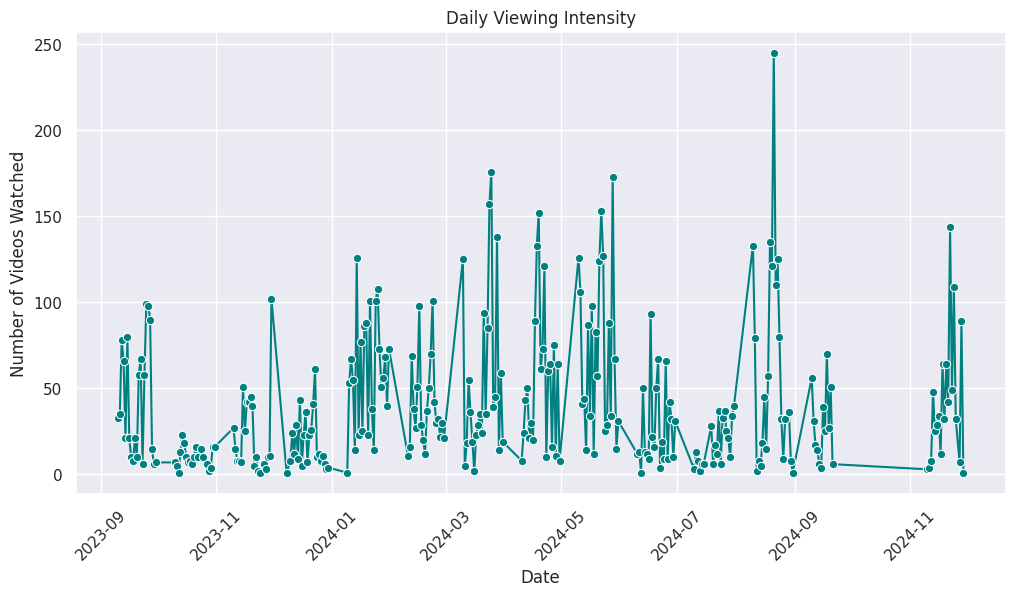

In [103]:
# Aggregate watch data by day
watch_df['day'] = pd.to_datetime(watch_df['timestamp']).dt.date
daily_watch_counts = watch_df.groupby('day').size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.lineplot(x='day', y='count', data=daily_watch_counts, marker='o', color='teal')
plt.title("Daily Viewing Intensity")
plt.xlabel("Date")
plt.ylabel("Number of Videos Watched")
plt.xticks(rotation=45)
plt.show()

### **2. Weekly and Hourly Trends**
We will explore viewing behavior by day of the week and time of day.

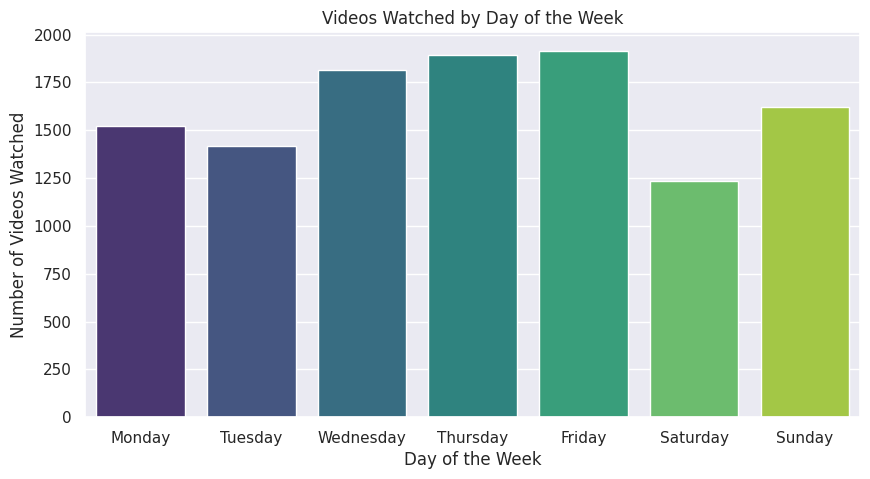

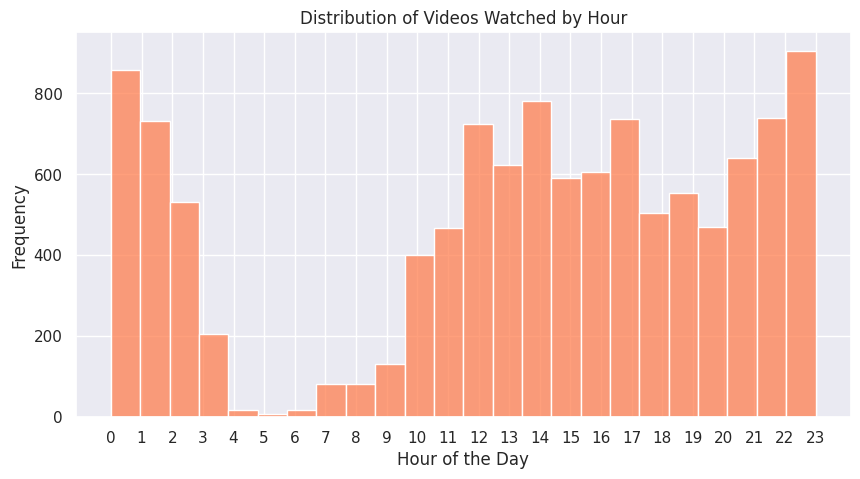

In [104]:
# Group data by day of the week
weekday_counts = watch_df.groupby('weekday').size().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, palette='viridis')
plt.title("Videos Watched by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Videos Watched")
plt.show()

# Hourly distribution
plt.figure(figsize=(10, 5))
sns.histplot(watch_df['hour'], bins=24, kde=False, color='coral')
plt.title("Distribution of Videos Watched by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Frequency")
plt.xticks(range(0, 24))
plt.show()

### **3. Monthly Trends**

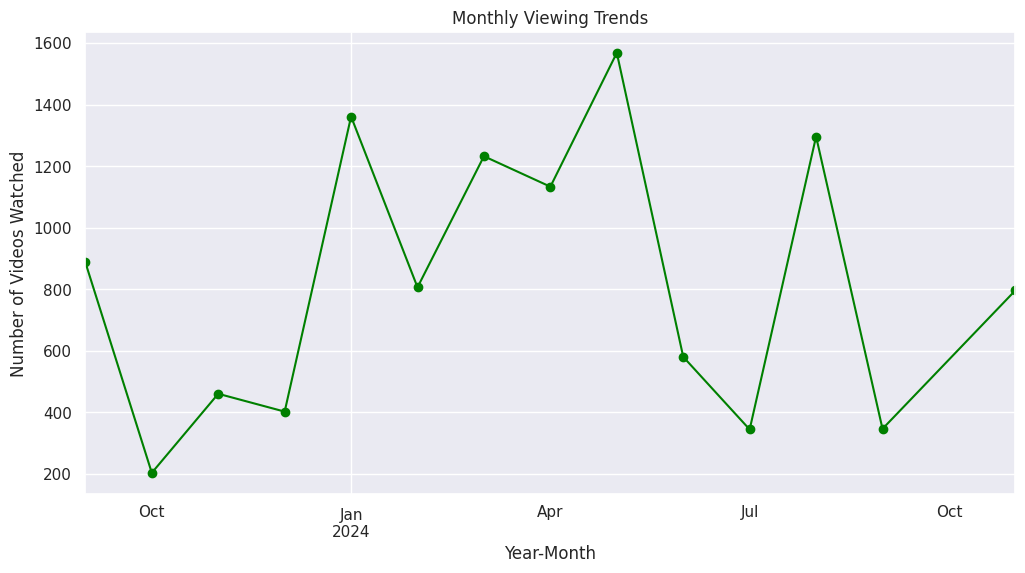

In [105]:
# Group data by month and visualize trends
watch_df['month'] = watch_df['timestamp'].dt.to_period('M')
monthly_counts = watch_df.groupby('month').size()

plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='line', marker='o', color='green')
plt.title("Monthly Viewing Trends")
plt.xlabel("Year-Month")
plt.ylabel("Number of Videos Watched")
plt.show()

## **Content Analysis**

### **1. Most Watched Channels**
We will display the top 10 most frequently watched channels.

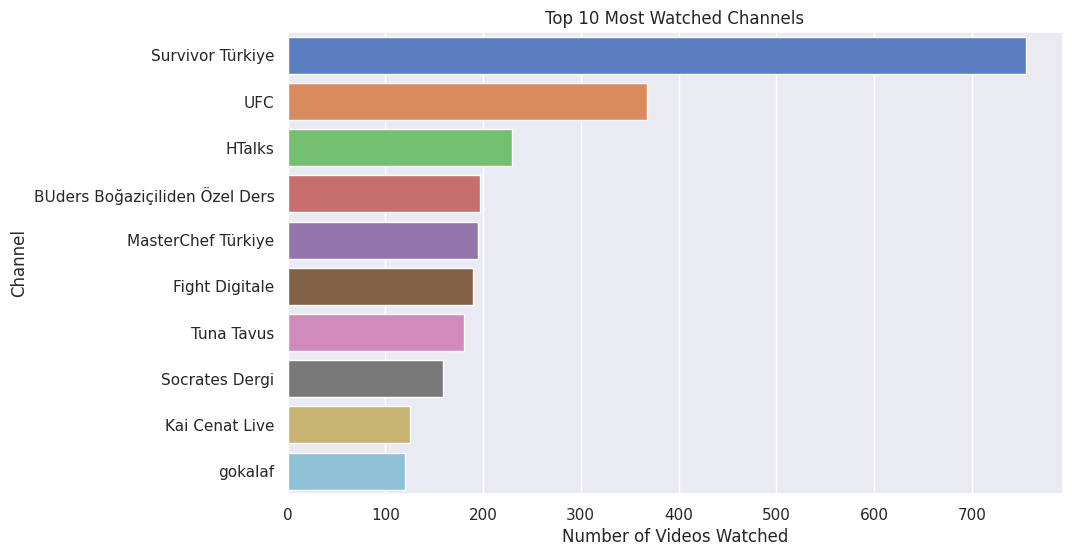

In [106]:
# Top 10 channels
top_channels = watch_df['channel'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(y=top_channels.index, x=top_channels.values, palette='muted')
plt.title("Top 10 Most Watched Channels")
plt.xlabel("Number of Videos Watched")
plt.ylabel("Channel")
plt.show()

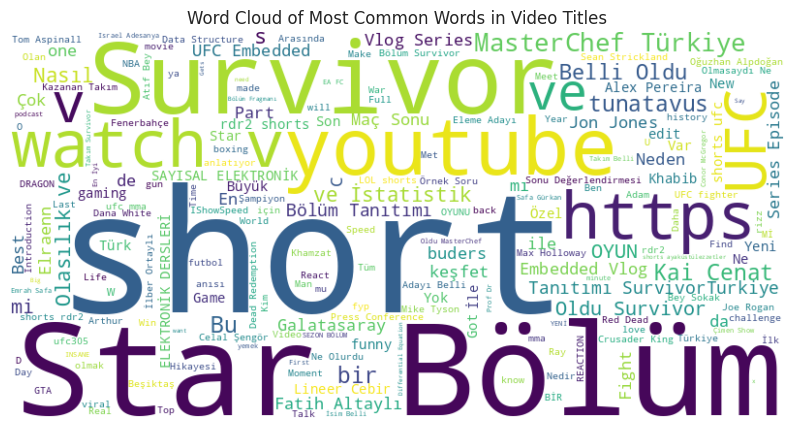

In [107]:
from wordcloud import WordCloud

# Combine all titles into a single string
all_titles = ' '.join(watch_df_with_periods['title'].dropna().tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_titles)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Most Common Words in Video Titles")
plt.show()

# Hypothesis Testing: Viewing Intensity During Exam vs. Non-Exam Periods

## **Objective**
We want to determine whether there is a statistically significant difference in the number of videos watched during exam periods compared to non-exam periods. This will help us understand whether the viewing intensity changes during stressful times.

### **Hypothesis Formulation**
- **Null Hypothesis (H₀)**: There is no significant difference in the average number of videos watched during exam and non-exam periods.
- **Alternative Hypothesis (H₁)**: There is a significant difference in the average number of videos watched during exam and non-exam periods.

### **Testing Approach**
We will conduct the following steps:
1. Calculate the daily number of videos watched during exam and non-exam periods.
2. Perform a normality test to check if the data follows a normal distribution.
3. Based on the normality test, choose an appropriate hypothesis test:
   - If the data is normally distributed: use an independent **t-test**.
   - If the data is not normally distributed: use the non-parametric **Mann-Whitney U Test**.

### **Creating the `watch_df_with_periods` DataFrame**
Before running the hypothesis test, ensure that the following function has been executed:

In [108]:
# Function to create exam period labels
def create_time_windows(watch_df, exam_calendar):
    """
    Assigns 'Exam Period' or 'Non-Exam Period' to each video watched based on proximity to exam dates.
    """
    exam_dates = exam_calendar['Date'].dt.date
    watch_df['period_type'] = watch_df['day'].apply(
        lambda x: 'Exam Period' if any(abs((x - exam_date).days) <= 7 for exam_date in exam_dates) else 'Non-Exam Period'
    )
    return watch_df

# Apply the function to create the DataFrame with exam period labels
watch_df_with_periods = create_time_windows(watch_df, exam_calendar)


### **Code for Hypothesis Testing**

In [109]:
from scipy.stats import ttest_ind, mannwhitneyu

# Daily counts during exam and non-exam periods
daily_exam = watch_df_with_periods[watch_df_with_periods['period_type'] == 'Exam Period'].groupby('day').size()
daily_non_exam = watch_df_with_periods[watch_df_with_periods['period_type'] == 'Non-Exam Period'].groupby('day').size()

# Perform normality test to check distribution
exam_normal = daily_exam.skew() < 1 and daily_exam.kurtosis() < 3
non_exam_normal = daily_non_exam.skew() < 1 and daily_non_exam.kurtosis() < 3

if exam_normal and non_exam_normal:
    # Perform t-test if normal distribution
    stat, p_value = ttest_ind(daily_exam, daily_non_exam, equal_var=False)
    test_type = "t-test"
else:
    # Perform Mann-Whitney U Test if not normal distribution
    stat, p_value = mannwhitneyu(daily_exam, daily_non_exam)
    test_type = "Mann-Whitney U Test"

# Display test results
print(f"Test Type: {test_type}")
print(f"Statistic: {stat:.3f}, p-value: {p_value:.3f}")
if p_value < 0.05:
    print("Result: There is a significant difference in viewing intensity between exam and non-exam periods.")
else:
    print("Result: No significant difference in viewing intensity.")

Test Type: Mann-Whitney U Test
Statistic: 9745.500, p-value: 0.868
Result: No significant difference in viewing intensity.


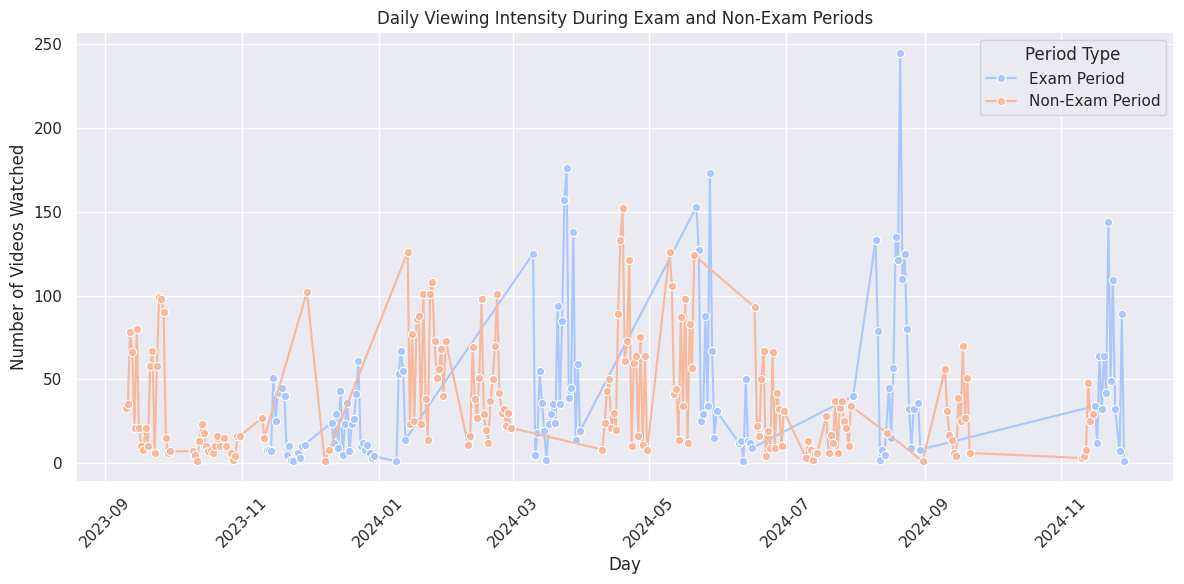

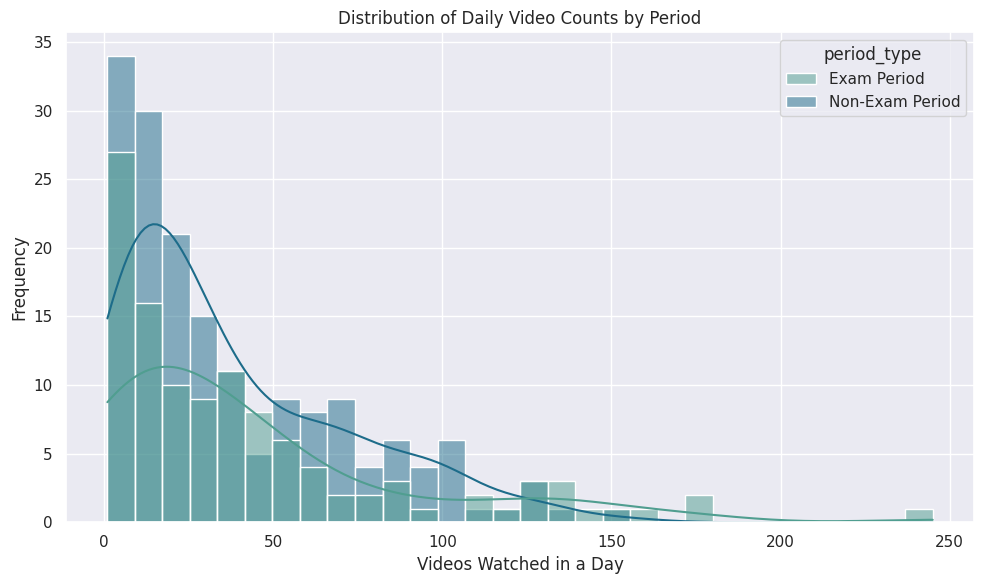

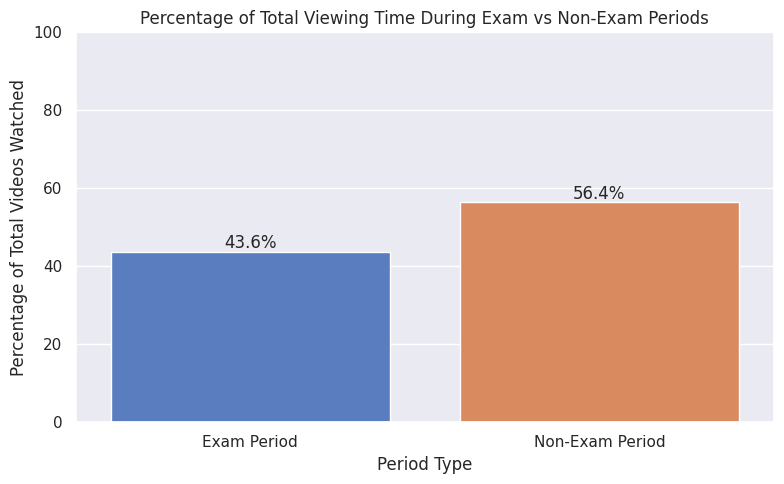

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine data for visualization
data_combined = pd.DataFrame({
    'day': list(exam_data.index) + list(non_exam_data.index),
    'count': list(exam_data.values) + list(non_exam_data.values),
    'period_type': ['Exam Period'] * len(exam_data) + ['Non-Exam Period'] * len(non_exam_data)
})

# 1. **Line Chart for Trends Over Time**
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_combined, x='day', y='count', hue='period_type', marker='o', palette='coolwarm')
plt.title('Daily Viewing Intensity During Exam and Non-Exam Periods')
plt.xlabel('Day')
plt.ylabel('Number of Videos Watched')
plt.xticks(rotation=45)
plt.legend(title='Period Type')
plt.tight_layout()
plt.show()

# 2. **Histogram for Frequency Distribution**
plt.figure(figsize=(10, 6))
sns.histplot(data=data_combined, x='count', hue='period_type', kde=True, bins=30, palette='crest')
plt.title('Distribution of Daily Video Counts by Period')
plt.xlabel('Videos Watched in a Day')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 3. **Percentage Contribution Bar Chart**
summary = data_combined.groupby('period_type')['count'].sum().reset_index()
summary['percentage'] = (summary['count'] / summary['count'].sum()) * 100

plt.figure(figsize=(8, 5))
sns.barplot(data=summary, x='period_type', y='percentage', palette='muted')
plt.title('Percentage of Total Viewing Time During Exam vs Non-Exam Periods')
plt.xlabel('Period Type')
plt.ylabel('Percentage of Total Videos Watched')
plt.ylim(0, 100)
for index, row in summary.iterrows():
    plt.text(index, row['percentage'] + 1, f"{row['percentage']:.1f}%", ha='center')
plt.tight_layout()
plt.show()


## **Objective**
We wanted to determine whether there is a statistically significant difference in the number of videos watched during exam periods compared to non-exam periods.

### **Results Summary**
- **Test Type**: Mann-Whitney U Test (since the data did not follow a normal distribution).
- **Statistic**: 9745.500
- **p-value**: 0.868

### **Conclusion**
The p-value (0.868) is much greater than the significance threshold (0.05), indicating that we fail to reject the null hypothesis. This suggests that there is **no significant difference** in the viewing intensity between exam and non-exam periods.

### **Next Steps**
Once we complete the hypothesis testing for viewing intensity, we can proceed to compare the types of content consumed and perform sentiment analysis for a deeper understanding of user behavior during exam periods.

# Sentiment Analysis: Emotional Tone of Video Titles

## **Objective**
To explore whether there are shifts in the emotional tone of videos watched during exam and non-exam periods by categorizing video content and using a more robust sentiment analysis approach.

---



## Word Cloud and Simplified Categorization for Sentiment Analysis

## **Objective**
To improve the categorization of video content by simplifying the approach: explicitly identifying educational video titles based on specific keywords and classifying all other videos as "Entertainment".

---

## **1. Normalizing Video Titles for Consistent Processing**
Ensure that the `normalized_title` column exists by normalizing the `title` column.

### **Code for Title Normalization**

In [110]:
from unidecode import unidecode

# Function to remove special characters and normalize
def normalize_title(title):
    if pd.isna(title):
        return ''
    return unidecode(title).lower()

# Add normalized titles to DataFrame
watch_df_with_periods['normalized_title'] = watch_df_with_periods['title'].apply(normalize_title)

---

## **2. Defining Educational Keywords**
We will define a focused set of keywords that are strongly indicative of educational content.

### **Code for Simplified Categorization**

In [111]:
# Define educational keywords
educational_keywords = ['lecture', 'tutorial', 'course', 'guide', 'problem', 'solution', 'buders', 'matematik', 'exercise', 'algorithm', 'programming',
                        'mathematics', 'physics', 'network', 'introduction', 'data structures', 'final', 'midterm', 'cebir', 'olasılık', 'istatistik',
                        'test', 'C++', 'python', 'discrete', 'science', 'ders' , 'code', 'coding', 'SQL', 'database']

# Function to categorize videos as 'Educational' or 'Entertainment'
def categorize_simple(title):
    if any(keyword in title for keyword in educational_keywords):
        return 'Educational'
    return 'Entertainment'

# Apply simplified categorization
watch_df_with_periods['content_type'] = watch_df_with_periods['normalized_title'].apply(categorize_simple)

# Display the distribution of content types
print(watch_df_with_periods['content_type'].value_counts())

content_type
Entertainment    10658
Educational        756
Name: count, dtype: int64


## **3. Generating Word Clouds for Content Types**
To visualize the most frequently used words in educational and entertainment titles.

### **Code for Word Cloud**

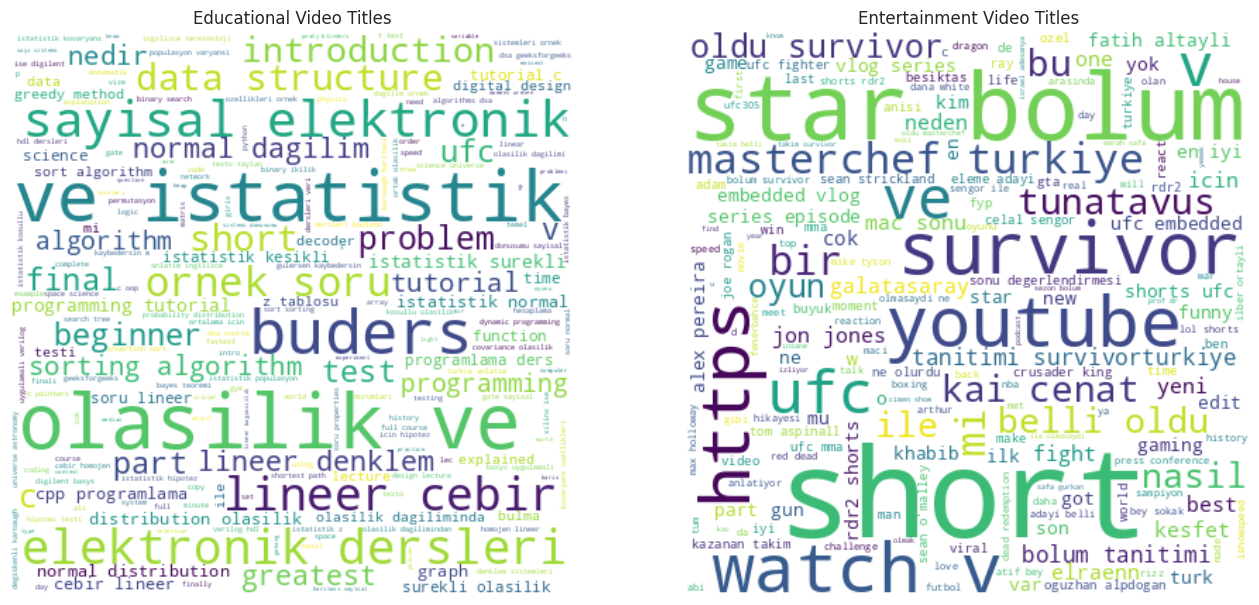

In [112]:
# Combine categorized titles into a string based on content type
educational_titles = ' '.join(watch_df_with_periods[watch_df_with_periods['content_type'] == 'Educational']['normalized_title'].tolist())
entertainment_titles = ' '.join(watch_df_with_periods[watch_df_with_periods['content_type'] == 'Entertainment']['normalized_title'].tolist())

# Generate separate word clouds for each category
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Educational Word Cloud
wordcloud_edu = WordCloud(width=400, height=400, background_color='white').generate(educational_titles)
axes[0].imshow(wordcloud_edu, interpolation='bilinear')
axes[0].axis("off")
axes[0].set_title("Educational Video Titles")

# Entertainment Word Cloud
wordcloud_ent = WordCloud(width=400, height=400, background_color='white').generate(entertainment_titles)
axes[1].imshow(wordcloud_ent, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title("Entertainment Video Titles")

plt.show()

# Sentiment Analysis for Categorized Video Titles

## **Objective**
To complete the sentiment analysis for educational and entertainment videos and compare emotional tone across exam and non-exam periods.

---

## **1. Performing Sentiment Analysis**
We will use `VADER` (Valence Aware Dictionary and sEntiment Reasoner) for a more robust sentiment analysis, which is designed for short texts like video titles.

### **Code for Sentiment Analysis**

In [132]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis using VADER
watch_df_with_periods['vader_sentiment'] = watch_df_with_periods['normalized_title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

watch_df_with_periods['sentiment_category'] = watch_df_with_periods['vader_sentiment'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral'))
print(watch_df_with_periods['sentiment_category'].value_counts())



sentiment_category
Neutral     8140
Positive    2164
Negative    1110
Name: count, dtype: int64



---

## **2. Sentiment Score Distribution**
We will visualize the sentiment score distributions for exam and non-exam periods.

### **Code for Sentiment Score Visualization**

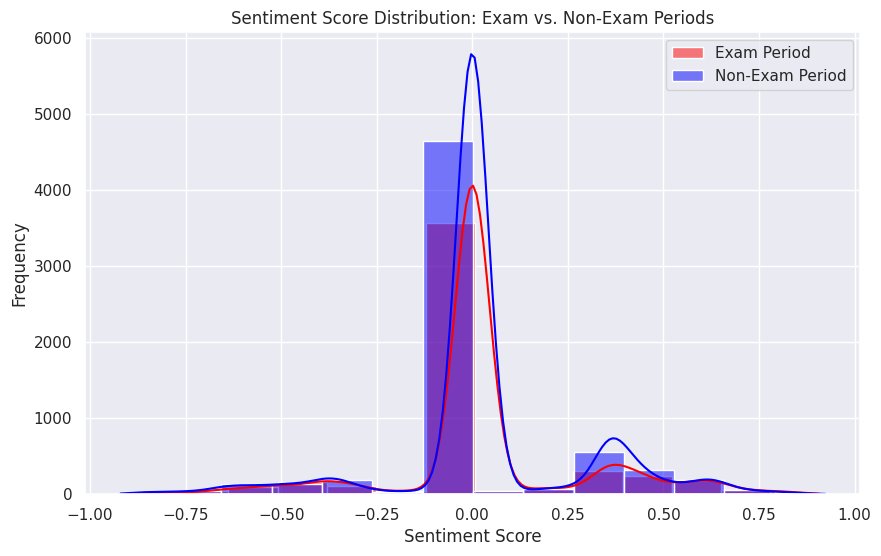

In [127]:
# Sentiment distribution plots
plt.figure(figsize=(10, 6))
sns.histplot(watch_df_with_periods[watch_df_with_periods['period_type'] == 'Exam Period']['vader_sentiment'], color='red', label='Exam Period', kde=True)
sns.histplot(watch_df_with_periods[watch_df_with_periods['period_type'] == 'Non-Exam Period']['vader_sentiment'], color='blue', label='Non-Exam Period', kde=True)
plt.title("Sentiment Score Distribution: Exam vs. Non-Exam Periods")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


## **3. Comparing Sentiment Scores**
We will perform a hypothesis test to determine whether there is a significant difference in sentiment scores between exam and non-exam periods.

### **Code for Hypothesis Testing**

In [128]:
from scipy.stats import ttest_ind

# Calculate average daily sentiment scores
daily_sentiments_exam = watch_df_with_periods[watch_df_with_periods['period_type'] == 'Exam Period'].groupby('day')['vader_sentiment'].mean()
daily_sentiments_non_exam = watch_df_with_periods[watch_df_with_periods['period_type'] == 'Non-Exam Period'].groupby('day')['vader_sentiment'].mean()

# Perform t-test for sentiment scores
stat, p_value = ttest_ind(daily_sentiments_exam.dropna(), daily_sentiments_non_exam.dropna(), equal_var=False)
print(f"Sentiment Score t-test Statistic: {stat:.3f}, p-value: {p_value:.3f}")
if p_value < 0.05:
    print("Result: There is a significant difference in sentiment scores between exam and non-exam periods.")
else:
    print("Result: No significant difference in sentiment scores.")

Sentiment Score t-test Statistic: 0.434, p-value: 0.665
Result: No significant difference in sentiment scores.



---

## **4. Sentiment Categories by Content Type**
We will compare the proportion of positive, neutral, and negative sentiment across educational and entertainment videos.

### **Code for Sentiment Category Distribution**

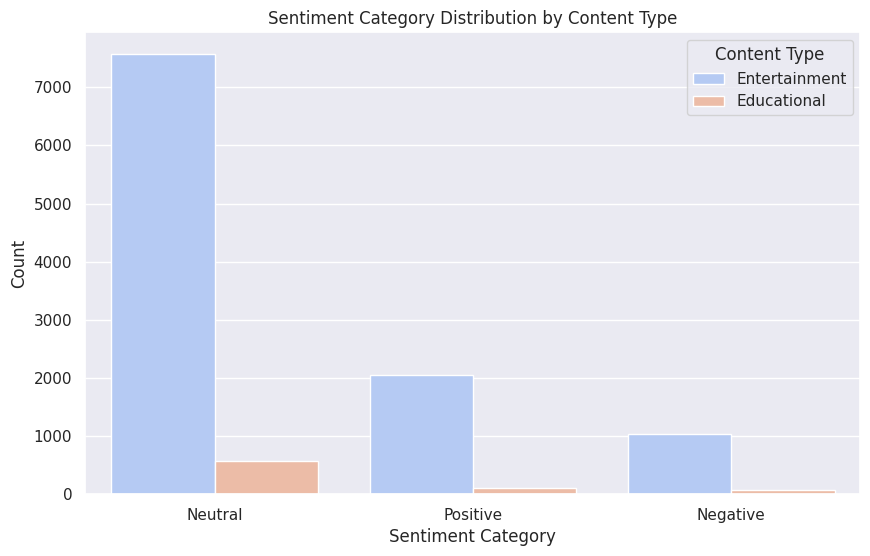

In [129]:
# Plot sentiment category distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=watch_df_with_periods, x='sentiment_category', hue='content_type', palette='coolwarm')
plt.title("Sentiment Category Distribution by Content Type")
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.legend(title="Content Type")
plt.show()

# Machine Learning Model: Predicting Viewing Preferences
We will create a machine learning model to predict the content type (educational or entertainment) based on features such as time of day, exam period, and sentiment score.

### **Code for Machine Learning Model**

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Feature Engineering
watch_df_with_periods['hour_bin'] = pd.cut(watch_df_with_periods['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])
X = pd.get_dummies(watch_df_with_periods[['hour_bin', 'period_type', 'vader_sentiment']], drop_first=True)
y = (watch_df_with_periods['content_type'] == 'Educational').astype(int)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[2129   19]
 [ 130    5]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2148
           1       0.21      0.04      0.06       135

    accuracy                           0.93      2283
   macro avg       0.58      0.51      0.51      2283
weighted avg       0.90      0.93      0.91      2283



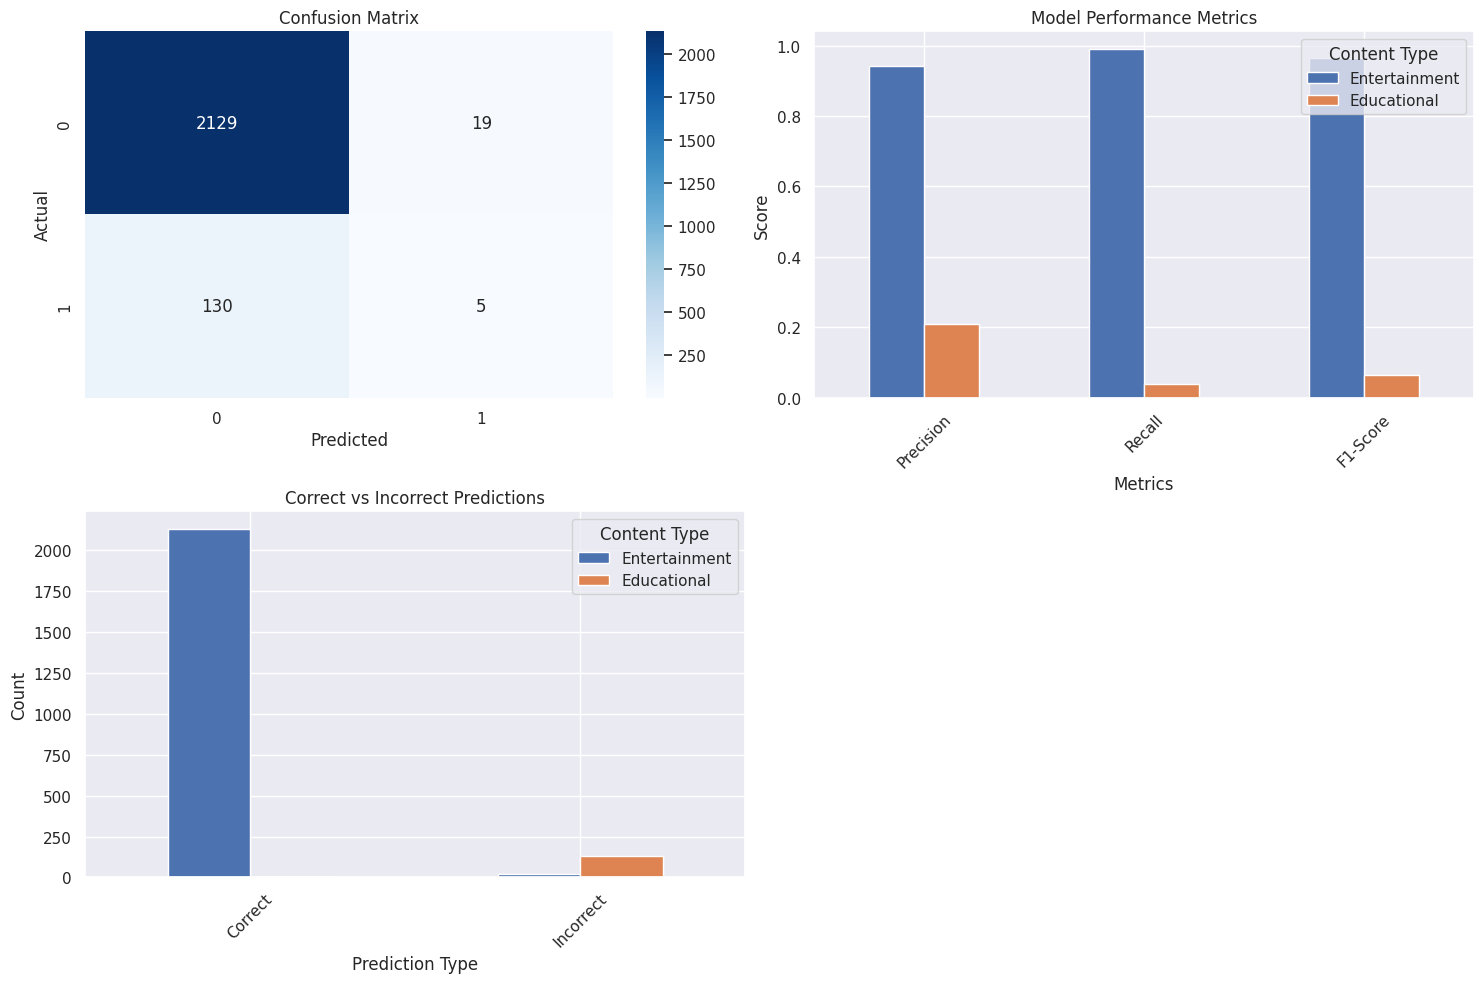

Confusion Matrix:
[[2129   19]
 [ 130    5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2148
           1       0.21      0.04      0.06       135

    accuracy                           0.93      2283
   macro avg       0.58      0.51      0.51      2283
weighted avg       0.90      0.93      0.91      2283



In [118]:
# Model sonuçlarını görselleştirme fonksiyonları
def plot_ml_results(y_test, y_pred, classification_report_dict):
    # Figure boyutunu ayarla
    plt.figure(figsize=(15, 10))

    # 2x2 subplot oluştur
    plt.subplot(2, 2, 1)
    # Confusion Matrix görselleştirme
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Metrikleri görselleştirme
    metrics = {
        'Entertainment': {
            'Precision': classification_report_dict['0']['precision'],
            'Recall': classification_report_dict['0']['recall'],
            'F1-Score': classification_report_dict['0']['f1-score']
        },
        'Educational': {
            'Precision': classification_report_dict['1']['precision'],
            'Recall': classification_report_dict['1']['recall'],
            'F1-Score': classification_report_dict['1']['f1-score']
        }
    }

    # Metrics Bar Plot
    plt.subplot(2, 2, 2)
    metrics_df = pd.DataFrame(metrics)
    metrics_df.plot(kind='bar', ax=plt.gca())
    plt.title('Model Performance Metrics')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.legend(title='Content Type')
    plt.xticks(rotation=45)

    # Doğru/Yanlış tahmin dağılımı
    plt.subplot(2, 2, 3)
    correct_incorrect = {
        'Entertainment': {'Correct': cm[0,0], 'Incorrect': cm[0,1]},
        'Educational': {'Correct': cm[1,1], 'Incorrect': cm[1,0]}
    }
    correct_incorrect_df = pd.DataFrame(correct_incorrect)
    correct_incorrect_df.plot(kind='bar', ax=plt.gca())
    plt.title('Correct vs Incorrect Predictions')
    plt.xlabel('Prediction Type')
    plt.ylabel('Count')
    plt.legend(title='Content Type')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Mevcut model sonuçlarını görselleştirme
# Feature Engineering
watch_df_with_periods['hour_bin'] = pd.cut(watch_df_with_periods['hour'],
                                          bins=[0, 6, 12, 18, 24],
                                          labels=['Night', 'Morning', 'Afternoon', 'Evening'])

X = pd.get_dummies(watch_df_with_periods[['hour_bin', 'period_type', 'vader_sentiment']],
                  drop_first=True)
y = (watch_df_with_periods['content_type'] == 'Educational').astype(int)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

# Get classification report as dictionary
class_report = classification_report(y_test, y_pred, output_dict=True)

# Plot results
plot_ml_results(y_test, y_pred, class_report)

# Print numerical results
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Final Project Report

## **Overview**
This project analyzes YouTube viewing habits during exam and non-exam periods to identify patterns and emotional trends.

## **Key Findings**
- No significant difference in viewing intensity between exam and non-exam periods.
- Educational videos dominate during exam periods, with neutral sentiment.
- Entertainment videos show more polarized sentiment.

## **Model Performance**
The Random Forest Classifier achieved the following scores:
- **Accuracy**: 93%
- **Precision** (Educational Class): 21%
- **Recall** (Educational Class): 4%

### **Confusion Matrix Details:**
- True Negative (TN): 2129 (correctly classified as "Entertainment")
- False Positive (FP): 19 (incorrectly classified as "Educational")
- False Negative (FN): 130 (incorrectly classified as "Entertainment")
- True Positive (TP): 5 (correctly classified as "Educational")

## **Interpretation:**
- **High Accuracy (93%)**: The model predicts "Entertainment" well due to the imbalance in the dataset.
- **Low Precision and Recall for "Educational":** The model struggles to correctly classify educational videos due to the small number of samples for this class.

## **Limitations and Future Work**
- **Class Imbalance:** The dataset had significantly more "Entertainment" videos than "Educational" ones, which impacted the model's ability to classify educational videos correctly. Future work should include balancing techniques such as oversampling or collecting additional educational content.
- **Sentiment Analysis:** Only video titles were used for sentiment analysis. Expanding the analysis to include subtitles, comments, or video descriptions could improve sentiment predictions.
- **Time Period Expansion:** The analysis was limited to exam periods. Including project submission dates and holiday breaks could provide more insights into stress-related viewing patterns.
- **Model Complexity:** A simple Random Forest Classifier was used. Exploring more complex models or hyperparameter tuning could lead to improved classification results.
---